In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 76.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.5 which is 

In [2]:
# -------------------------
# 1) Read and combine HR signals from WFDB files
# -------------------------

import os
import wfdb
import pandas as pd

input_dir = "/kaggle/input/stress-recognition-in-automobile-drivers/physionet.org/files/drivedb/1.0.0/"
all_hr_signals = pd.DataFrame()  # holds columns for each driver's HR

for file in sorted(os.listdir(input_dir)):
    if file.endswith(".dat"):
        # remove .dat to get the base file path
        file_path = os.path.join(input_dir, os.path.splitext(file)[0])
        # read signals and metadata
        signals, fields = wfdb.rdsamp(file_path)
        # list of channel names
        signal_names = fields['sig_name']
        
        if "HR" in signal_names:
            # index of HR channel
            hr_index = signal_names.index("HR")
            # extract the HR column
            hr_signal = signals[:, hr_index]
            # add HR to DataFrame under the driver_id column
            driver_id = os.path.splitext(file)[0]
            all_hr_signals[driver_id] = pd.Series(hr_signal)

# display a small portion
print(all_hr_signals.head())

   drive01    drive02  drive04  drive05  drive06  drive07  drive08  drive09  \
0     84.0  74.992501     53.0     89.0     90.0     88.0     59.0     78.0   
1     84.0  74.992501     53.0     89.0     90.0     88.0     56.0     78.0   
2     84.0  77.992201     53.0     89.0     90.0     88.0     56.0     78.0   
3     84.0  77.992201     68.0     89.0     90.0     88.0     56.0     78.0   
4     84.0  77.992201     68.0     89.0     90.0     88.0     56.0     78.0   

   drive10  drive11  drive12  drive13  drive15  drive16  drive17a  drive17b  
0     78.0     70.0     89.0     82.0     91.0     81.0      77.0      70.0  
1     78.0     70.0     89.0     82.0     91.0     81.0      85.0      70.0  
2     78.0     70.0     89.0     82.0     91.0     81.0      85.0      70.0  
3     78.0     70.0     89.0     82.0     91.0     81.0      85.0      70.0  
4     78.0     70.0     89.0     82.0     91.0     81.0      85.0      70.0  


In [3]:
# -------------------------
# 2) Example scaling of the entire DataFrame (StandardScaler)
# -------------------------

import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # create scaler
scaled_array = scaler.fit_transform(all_hr_signals)  # fit and transform
scaled_df = pd.DataFrame(scaled_array, columns=all_hr_signals.columns)  # rewrap
print(scaled_df.head())

    drive01   drive02   drive04  drive05   drive06   drive07   drive08  \
0 -0.272186  0.324022 -1.528848  0.92718 -0.174357  1.684349 -0.566700   
1 -0.272186  0.324022 -1.528848  0.92718 -0.174357  1.684349 -0.716961   
2 -0.272186  0.556463 -1.528848  0.92718 -0.174357  1.684349 -0.716961   
3 -0.272186  0.556463 -0.653087  0.92718 -0.174357  1.684349 -0.716961   
4 -0.272186  0.556463 -0.653087  0.92718 -0.174357  1.684349 -0.716961   

    drive09   drive10   drive11   drive12   drive13   drive15   drive16  \
0  0.392928 -0.087677 -0.057048  0.478849 -1.069873  1.046771 -1.208655   
1  0.392928 -0.087677 -0.057048  0.478849 -1.069873  1.046771 -1.208655   
2  0.392928 -0.087677 -0.057048  0.478849 -1.069873  1.046771 -1.208655   
3  0.392928 -0.087677 -0.057048  0.478849 -1.069873  1.046771 -1.208655   
4  0.392928 -0.087677 -0.057048  0.478849 -1.069873  1.046771 -1.208655   

   drive17a  drive17b  
0  0.255075  -0.18477  
1  1.175723  -0.18477  
2  1.175723  -0.18477  
3  1.175

In [4]:
# -------------------------
# 3) BatchLoader class for segmenting and windowing
# -------------------------

from sklearn.preprocessing import MinMaxScaler

class BatchLoader:
    def __init__(self, data, batch_size, window_size, max_duration_minutes, max_duration_hours=1, sample_rate=1):
        self.data = data  # entire HR DataFrame
        self.batch_size = batch_size  # number of windows in one batch
        self.window_size = window_size  # number of samples per window
        # limit each driver to this many samples total
        self.max_samples_per_driver = int(max_duration_hours * 60 * 60 * sample_rate)
        # each segment is max_duration_minutes long
        self.max_samples = int(max_duration_minutes * 60 * sample_rate)
        self.sample_rate = sample_rate
        self.drivers = self.data.columns.tolist()  # driver IDs
        self.batches = self._prepare_batches()  # list of batches
    
    def _prepare_batches(self):
        batches = []  # store all generated batches
        for driver in self.drivers:
            # limit signals to 'max_samples_per_driver' length
            signal = self.data[driver].dropna().values[:self.max_samples_per_driver].reshape(-1, 1)
            # number of full segments
            num_segments = len(signal) // self.max_samples
            # create segments
            segments = [signal[i*self.max_samples:(i+1)*self.max_samples] for i in range(num_segments)]
            remainder = len(signal) % self.max_samples
            if remainder != 0:
                # last partial segment if any
                segments.append(signal[-remainder:])

            for segment in segments:
                # scale each segment
                seg_scaler = MinMaxScaler()
                normalized = seg_scaler.fit_transform(segment).flatten()
                # break segment into windows
                num_windows = len(normalized) // self.window_size
                windows = [normalized[i*self.window_size:(i+1)*self.window_size] 
                           for i in range(num_windows)]
                # group windows into batches
                for i in range(0, len(windows), self.batch_size):
                    batch = windows[i:i+self.batch_size]
                    if len(batch) > 0:
                        batch_np = np.expand_dims(np.array(batch), axis=-1)
                        batches.append(batch_np)
        return batches  # list of np.ndarray

    def __len__(self):
        return len(self.batches)  # total number of batches

    def __getitem__(self, idx):
        return self.batches[idx]  # get one batch by index

In [5]:
# -------------------------
# 4) Create a BatchLoader instance
# -------------------------

batch_size = 128
window_size = 50
max_duration_minutes = 5
max_duration_hours = 0.5
loader = BatchLoader(all_hr_signals, batch_size, window_size, max_duration_minutes, max_duration_hours)
batch0 = loader[0]
print("First batch shape:", batch0.shape)
print("Total batches:", len(loader))


First batch shape: (6, 50, 1)
Total batches: 96


In [6]:
# -------------------------
# 5) Optional GPU setup + mixed precision
# -------------------------

import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Dynamic GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

set_global_policy('mixed_float16')

Dynamic GPU memory growth enabled.


In [7]:
# -------------------------
# 6) Simple LSTM Autoencoder
# -------------------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()  # create model
model.add(LSTM(128, activation='relu', input_shape=(window_size, 1), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(window_size)) 
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer=Adam(learning_rate=1e-4, clipvalue=1.0), loss='mse')
#model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# -------------------------
# 7) Train loop (simple example)
# -------------------------

train_losses = []  # store epoch losses
epochs = 15

for epoch in range(epochs):
    epoch_loss = 0.0
    for i in range(len(loader)):
        x_batch = loader[i]  # batch data
        loss = model.train_on_batch(x_batch, x_batch)  # autoencoder => same input/target
        epoch_loss += loss
        print(f"Epoch {epoch+1}, Batch {i+1}/{len(loader)}, Loss={loss:.4f}", end='\r')
    avg_loss = epoch_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Avg Loss={avg_loss:.4f}")

I0000 00:00:1737747959.053091     103 service.cc:145] XLA service 0x5d1ff32302e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737747959.053154     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1737747966.696602     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_broadcast_multiply_fusion_1', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1737747966.712615     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1, Avg Loss=0.2264ss=0.1636
Epoch 2, Avg Loss=0.1319ss=0.1126
Epoch 3, Avg Loss=0.1006ss=0.0922
Epoch 4, Avg Loss=0.0856ss=0.0807
Epoch 5, Avg Loss=0.0763ss=0.0728
Epoch 6, Avg Loss=0.0699ss=0.0674
Epoch 7, Avg Loss=0.0649ss=0.0627
Epoch 8, Avg Loss=0.0606ss=0.0587
Epoch 9, Avg Loss=0.0569ss=0.0556
Epoch 10, Avg Loss=0.0540ss=0.0527
Epoch 11, Avg Loss=0.0514ss=0.0503
Epoch 12, Avg Loss=0.0493ss=0.0487
Epoch 13, Avg Loss=0.0477ss=0.0468
Epoch 14, Avg Loss=0.0459ss=0.0451
Epoch 15, Avg Loss=0.0442ss=0.0435


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

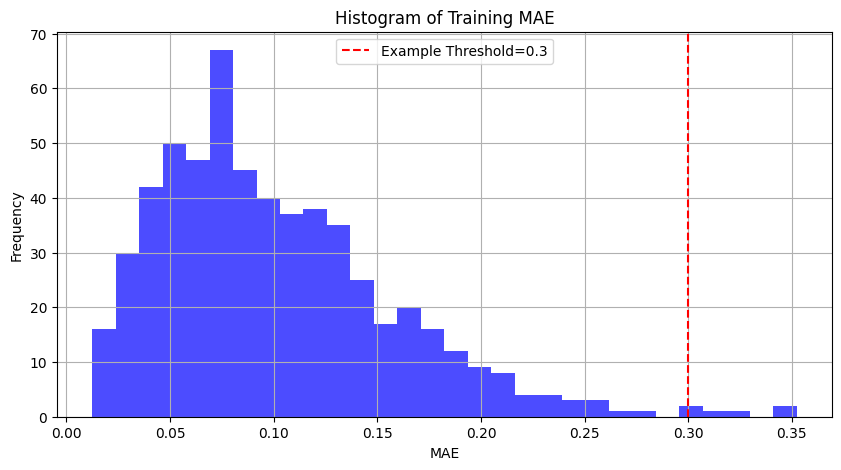

90th percentile threshold: 0.17529740106491826


In [10]:
# -------------------------
# 8) Compute MAE + histogram (training)
# -------------------------

import matplotlib.pyplot as plt
all_mae = []

for i in range(len(loader)):
    x_batch = loader[i]
    preds = model.predict(x_batch)
    mae = np.mean(np.abs(preds - x_batch), axis=(1, 2))
    all_mae.extend(mae)

plt.figure(figsize=(10, 5))
plt.hist(all_mae, bins=30, color='blue', alpha=0.7)
plt.axvline(x=0.3, color='red', linestyle='--', label='Example Threshold=0.3')
plt.xlabel("MAE")
plt.ylabel("Frequency")
plt.title("Histogram of Training MAE")
plt.grid(True)
plt.legend()
plt.show()

threshold = np.percentile(all_mae, 90)
print("90th percentile threshold:", threshold)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


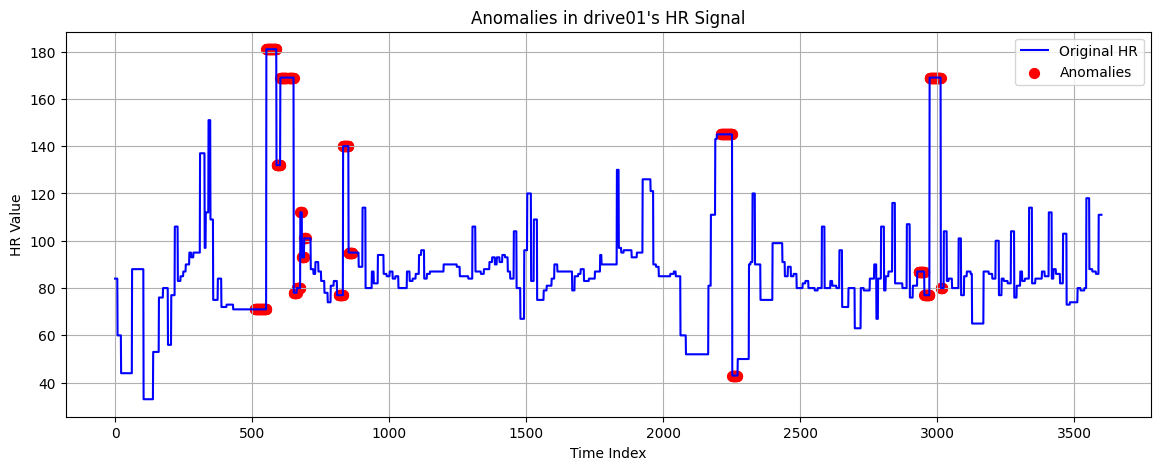

drive01 Anomalous windows: 88
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


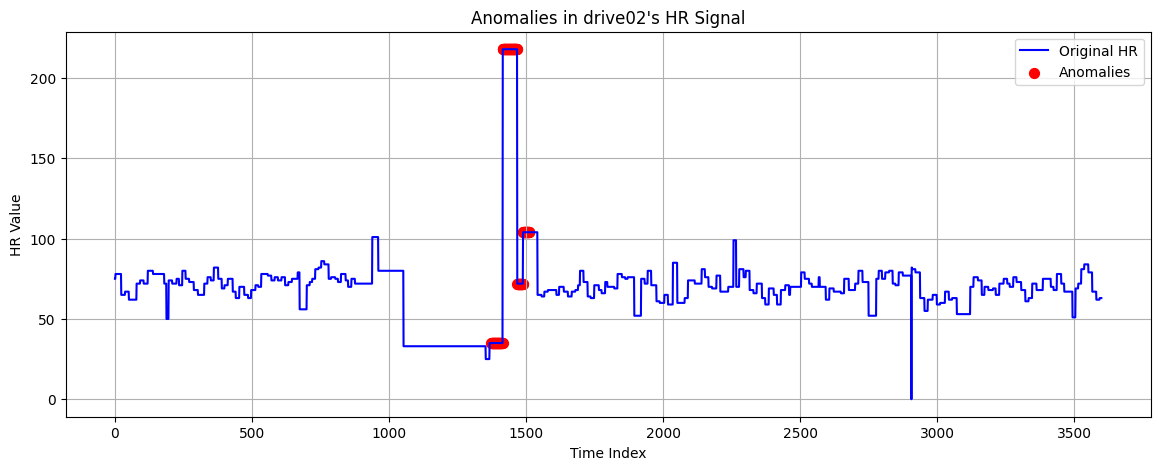

drive02 Anomalous windows: 53
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


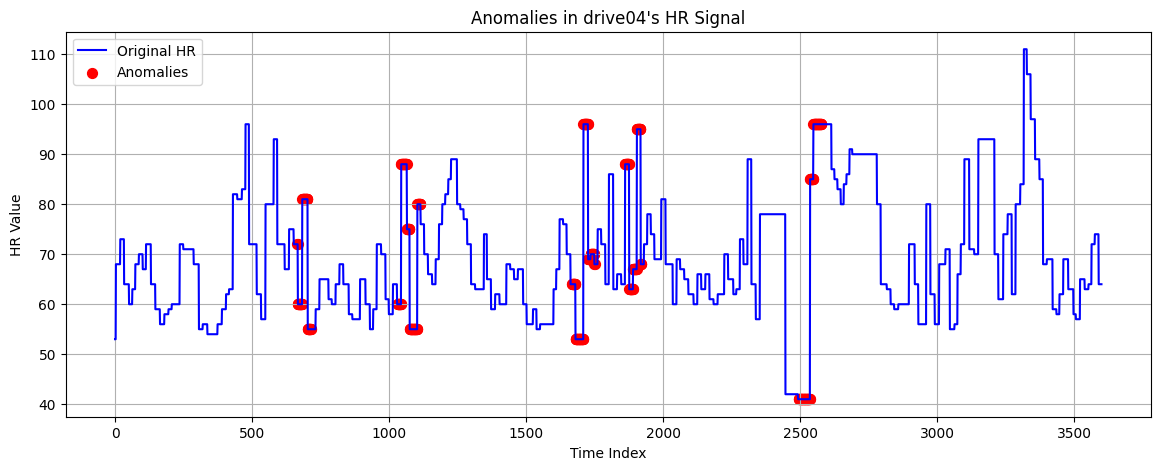

drive04 Anomalous windows: 92
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


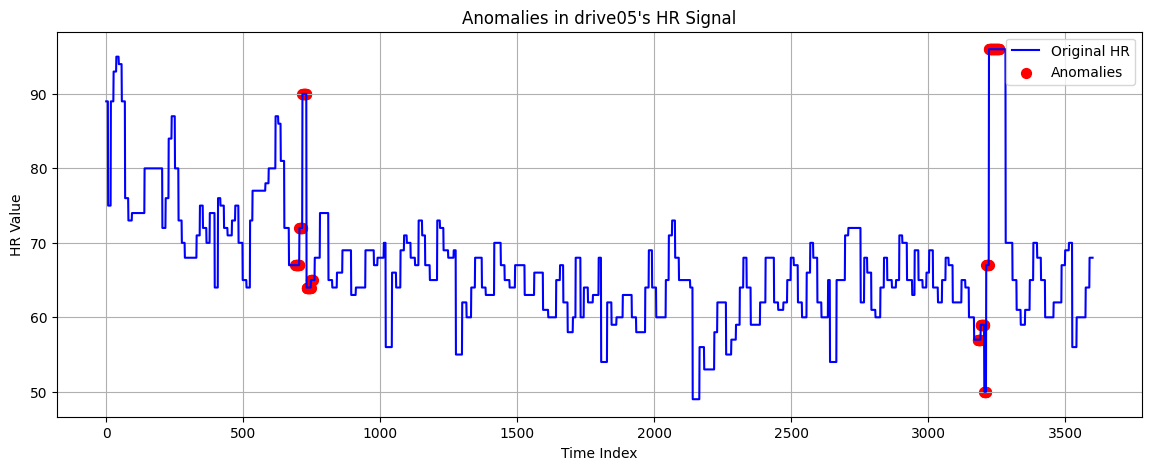

drive05 Anomalous windows: 41
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


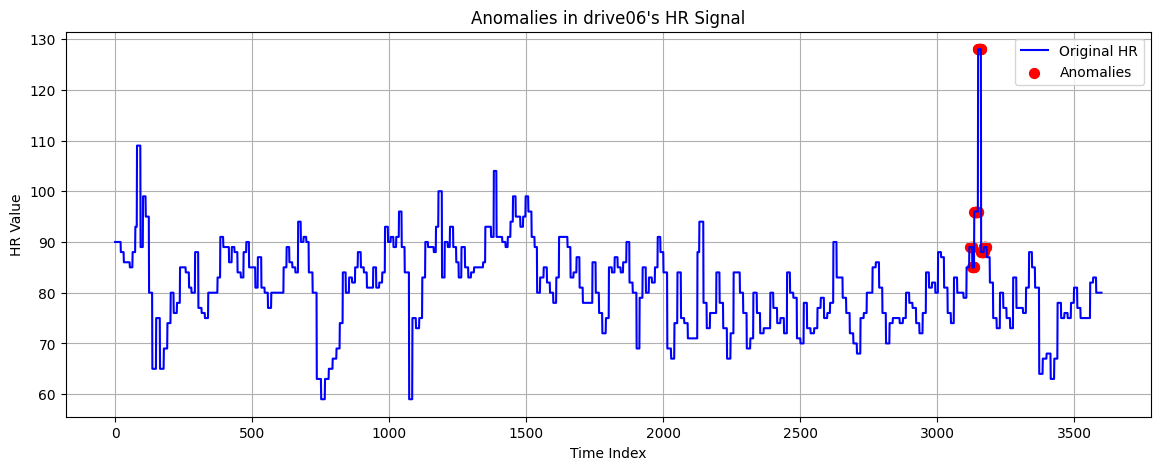

drive06 Anomalous windows: 8
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


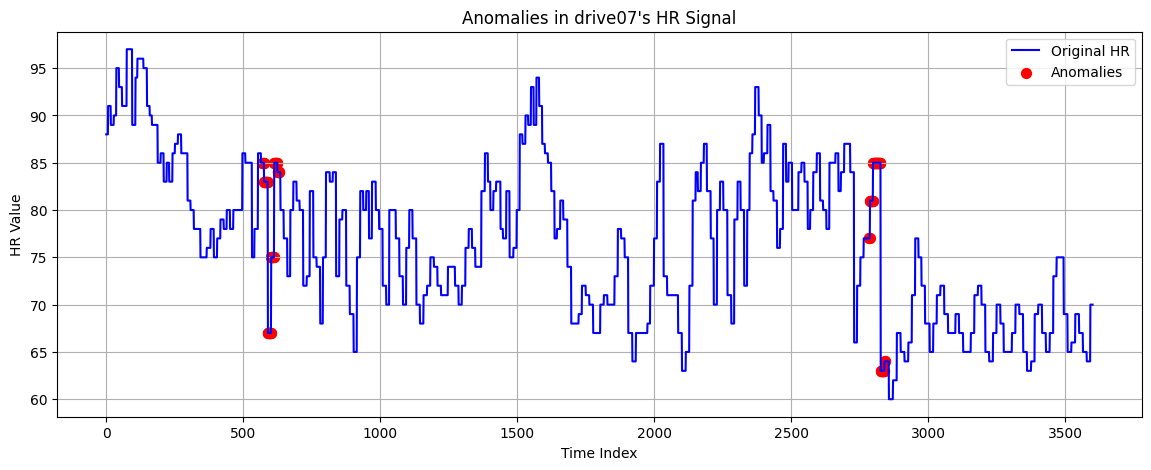

drive07 Anomalous windows: 22
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


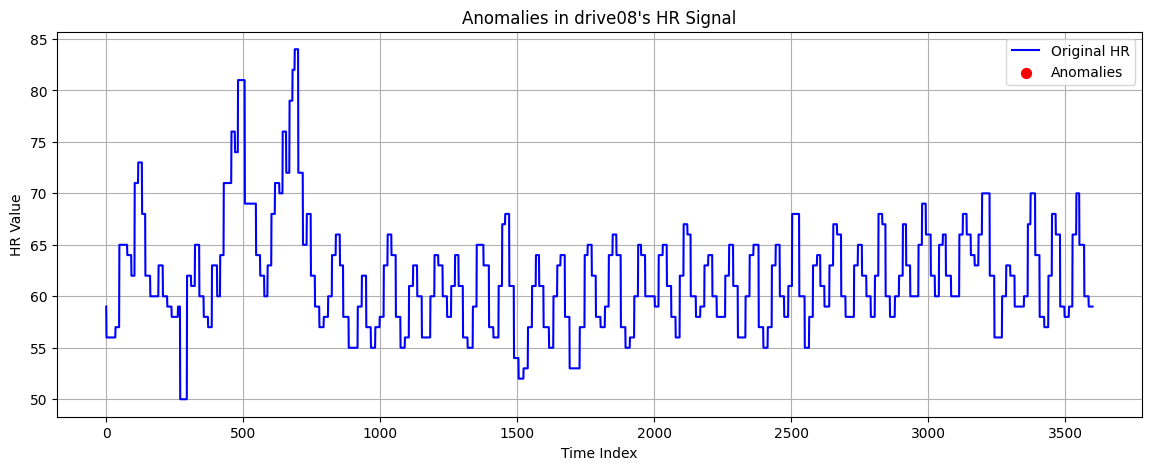

drive08 Anomalous windows: 0
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


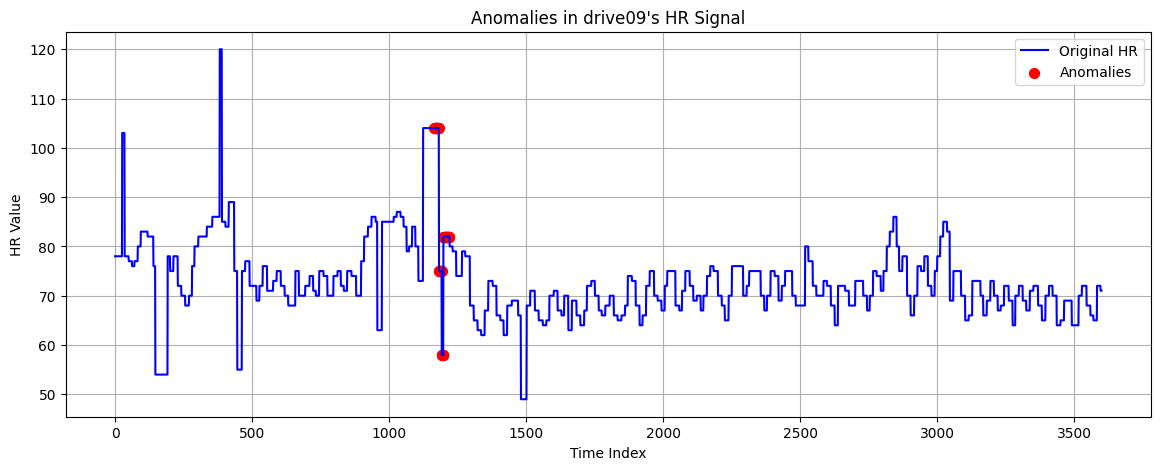

drive09 Anomalous windows: 6
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


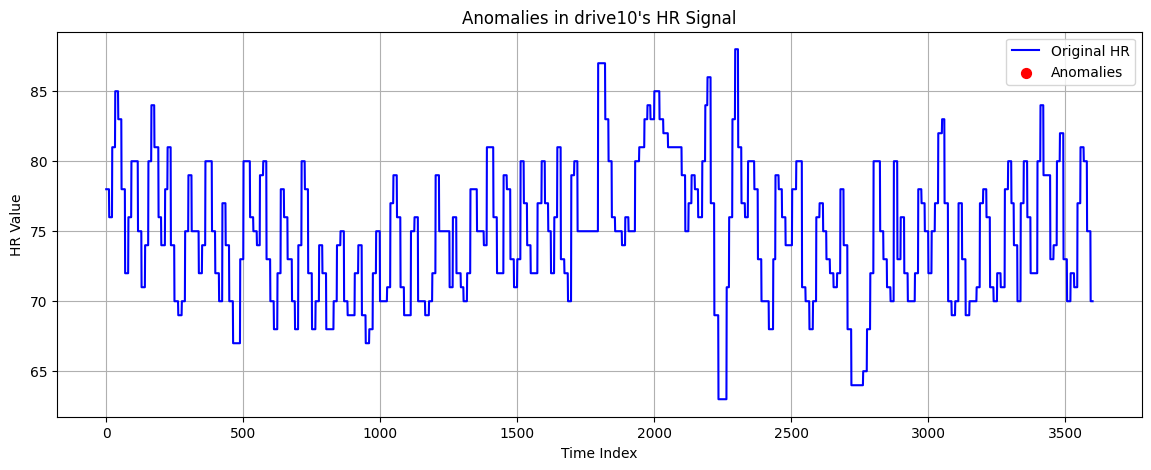

drive10 Anomalous windows: 0
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


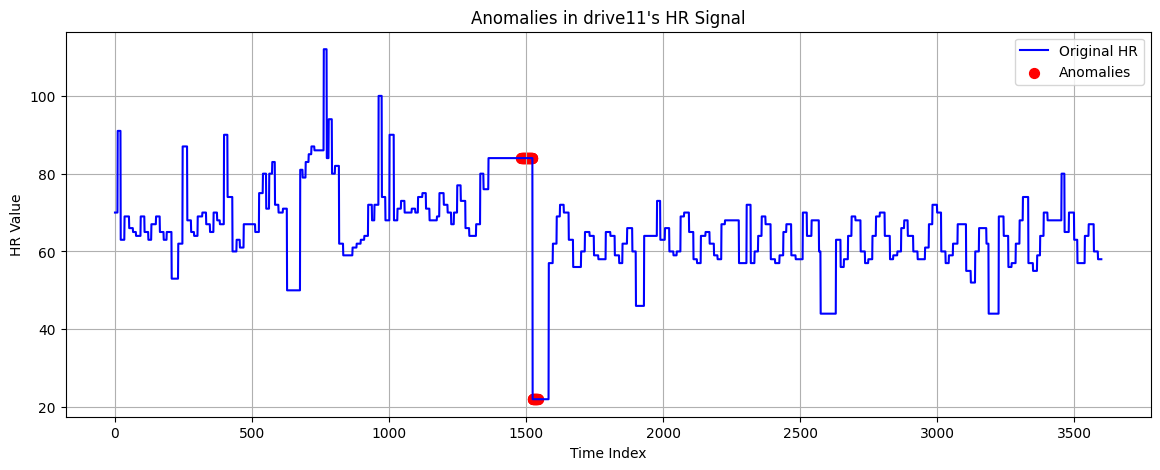

drive11 Anomalous windows: 13
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


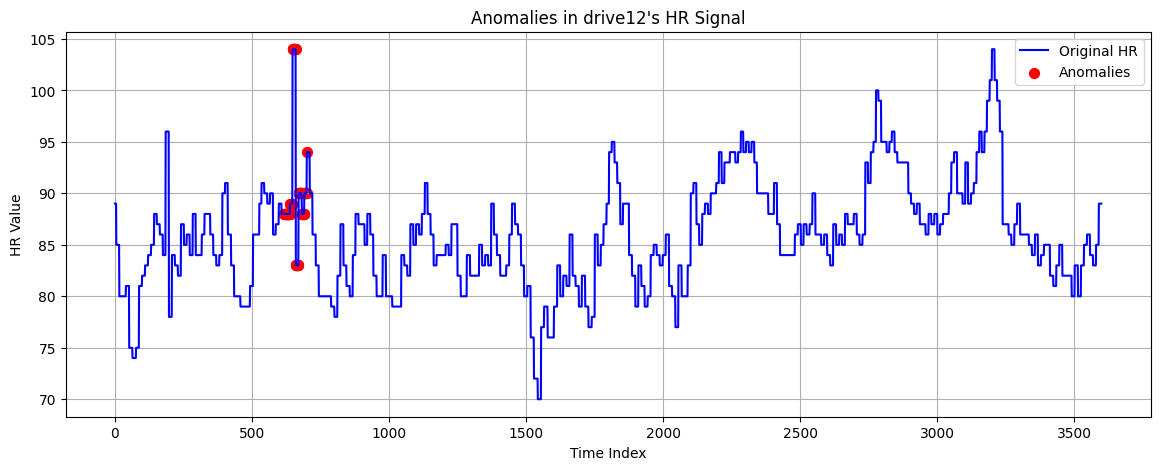

drive12 Anomalous windows: 34
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


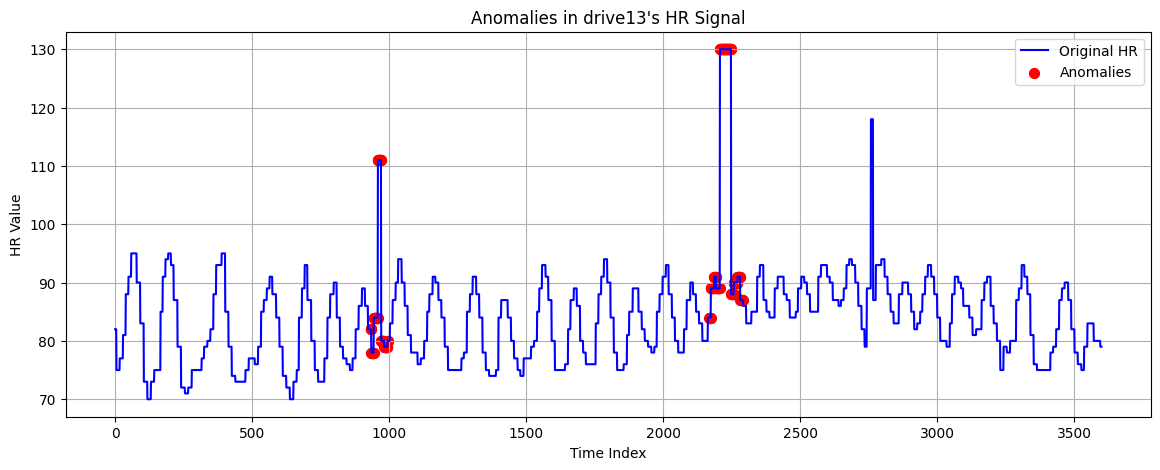

drive13 Anomalous windows: 52
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


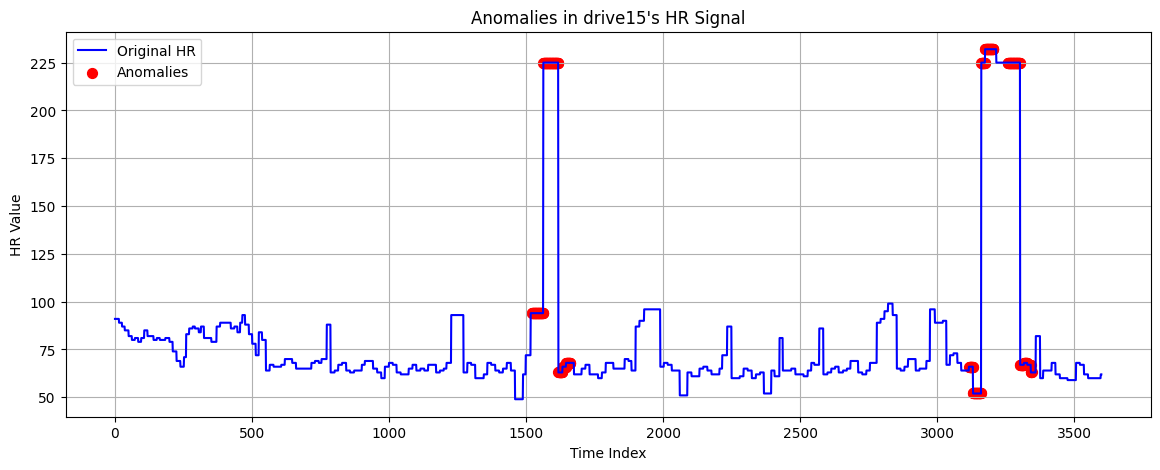

drive15 Anomalous windows: 128
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


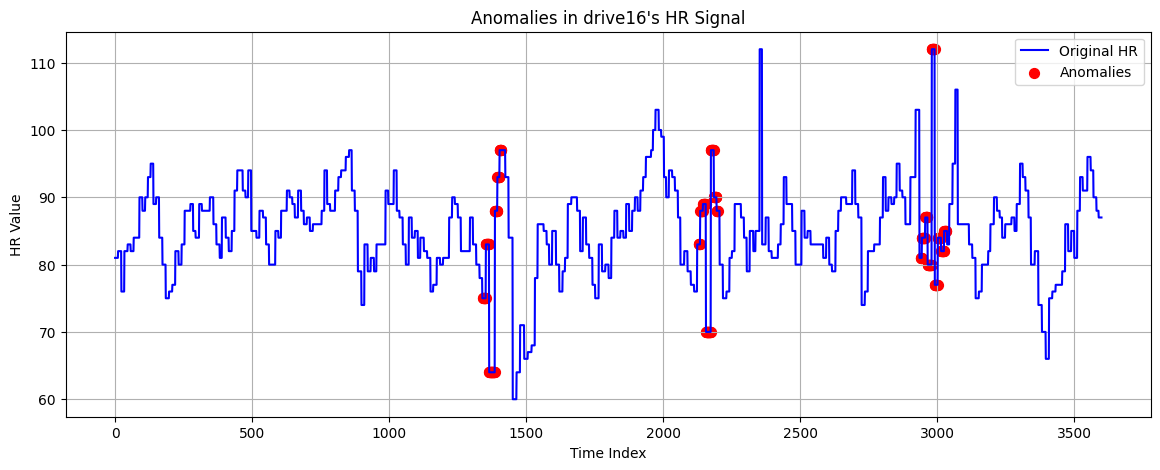

drive16 Anomalous windows: 83
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


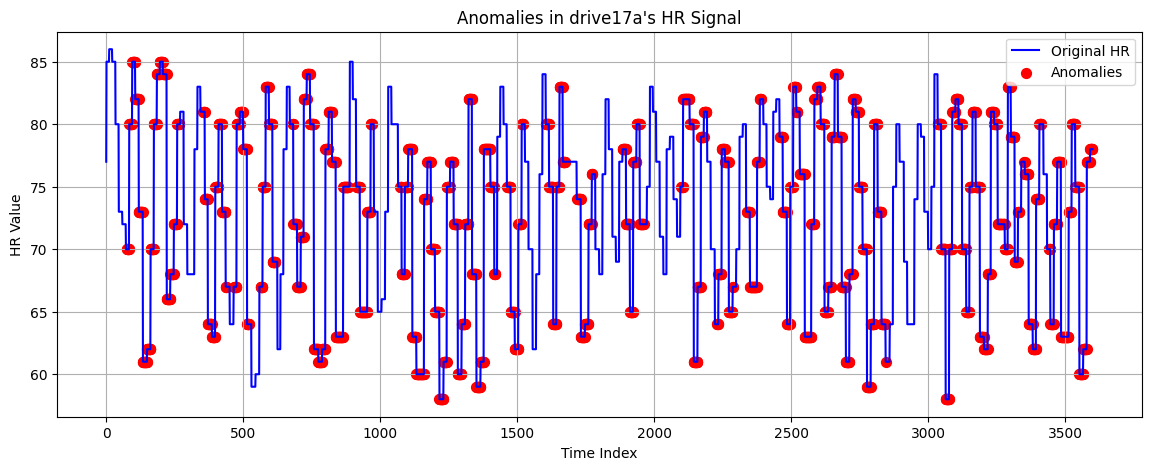

drive17a Anomalous windows: 616
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


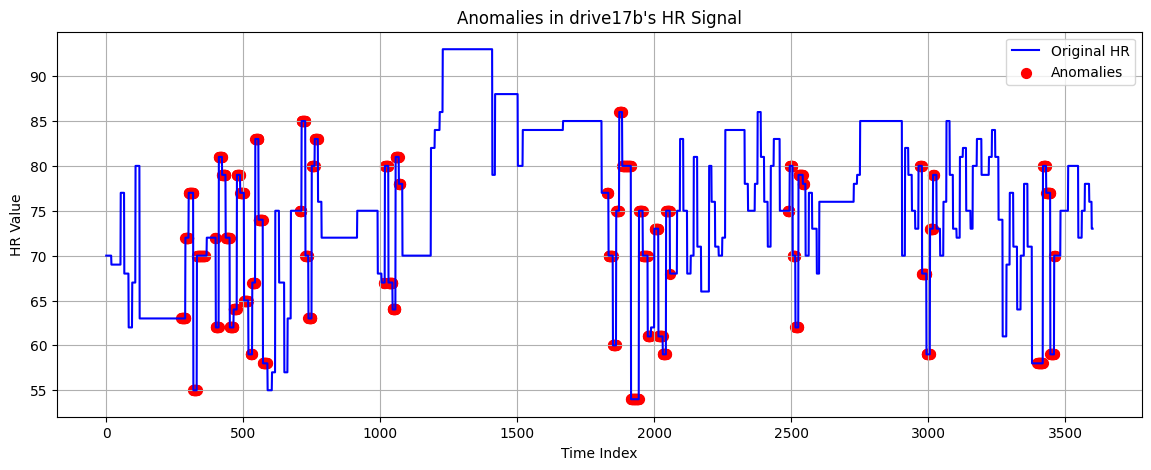

drive17b Anomalous windows: 174


In [13]:
# -------------------------
# 9) Anomaly detection plot for each driver
# -------------------------
anomaly_threshold = 0.16     # example threshold
max_duration_samples = 3600  # how many samples to analyze per driver
seq_size = 50               # same window_size used by model

for driver in all_hr_signals.columns:
    raw_data = all_hr_signals[driver].dropna().values[:max_duration_samples].reshape(-1, 1)
    mm_scaler = MinMaxScaler()
    scaled_data = mm_scaler.fit_transform(raw_data)
    
    # function to create sequences
    def to_seq(data, seq):
        seqs = []
        for i in range(len(data) - seq):
            seqs.append(data[i:i+seq])
        return np.array(seqs)
    
    testX = to_seq(scaled_data, seq_size)
    test_preds = model.predict(testX)
    test_mae = np.mean(np.abs(test_preds - testX), axis=(1, 2))
    
    anom_indices = np.where(test_mae > anomaly_threshold)[0]
    anom_points = []
    for idx in anom_indices:
        anom_points.extend(range(idx, idx + seq_size))
    anom_points = sorted(set(anom_points))
    
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(raw_data)), raw_data, color='blue', label='Original HR')
    plt.scatter(anom_points, raw_data[anom_points], color='red', label='Anomalies', s=50)
    plt.title(f"Anomalies in {driver}'s HR Signal")
    plt.xlabel("Time Index")
    plt.ylabel("HR Value")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print(f"{driver} Anomalous windows: {len(anom_indices)}")